In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 

In [2]:
# Вспомогательные функции
# q - квартенион системы
# J - тензор инерции
# w -  угловая скорость

#Нормирует объект
def normalize(obj):

    return obj / np.linalg.norm(obj)

def normalize_q(q0, q1, q2, q3) : 
    norm = np.sqrt(q0**2 + q1**2 + q2**2 + q3**2)
    
    q0 = q0/norm
    q1 = q1/norm
    q2 = q2/norm
    q3 = q3/norm
    
    return q0, q1, q2, q3

#Векторное произведение векторов
def cross_product(a, b):
    #Проверка на раззмерность и корректную длину вектора
    def check_dimensions(vec, string):

        if vec.ndim != 1:
            raise Exception("The {} input is not a vector".format(string))
        if len(vec) != 3:
            raise Exception("Wrong number of coordinates in the {0} vector: {1}, should be 3".format(string, len(vec)))

    check_dimensions(a, 'first')
    check_dimensions(b, 'second')

    return np.array([a[1]*b[2]-a[2]*b[1], a[2]*b[0]-a[0]*b[2], a[0]*b[1] - a[1]*b[0]])

#Произведение квартенионов
def quat_product(q1, q2):
    
    def check_dimensions(q, string):

        if q.ndim != 1:
            raise Exception("The {} input is not a quaternion".format(string))
        if len(q) != 4:
            raise Exception("Wrong number of coordinates in the {0} quaternion: {1}, should be 4".format(string, len(q)))

    check_dimensions(q1, 'first')
    check_dimensions(q2, 'second')

    q = np.zeros(4)
    q[0] = q1[0] * q2[0] - q1[1:].dot(q2[1:])
    q[1:] = q1[0] * q2[1:] + q2[0] * q1[1:] + cross_product(q1[1:], q2[1:])

    return q

#Поворачивает вектор в соответсвии с квартенионом
def rotate_vec_with_quat(q, vec):

    def check_dimensions(obj, is_quat):

        if obj.ndim != 1:
            raise Exception("Not a {}".format('quaternion' * is_quat + 'vector' * (1 - is_quat)))
        if len(obj) != (3 + 1 * is_quat):
            raise Exception("Wrong number of coordinates in the {0}: {1}, should be {2}"
                            .format('quaternion' * is_quat + 'vector' * (1 - is_quat), len(obj), 3 + 1 * is_quat))

    check_dimensions(q, True)
    check_dimensions(vec, False)

    q = quat_conjugate(q)

    qxvec = cross_product(q[1:], vec)

    return q[1:].dot(vec) * q[1:] + q[0]**2. * vec + 2. * q[0] * qxvec + cross_product(q[1:], qxvec)

#Это походу углы Эйлера
#https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%8F%D0%B7%D0%B0%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0_%D0%BA%D0%BE%D0%BE%D1%80%D0%B4%D0%B8%D0%BD%D0%B0%D1%82
def quat2rpy(q0, q1, q2, q3):
    q0, q1, q2, q3 = normalize_q(q0, q1, q2, q3)
    
    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))

    return [roll, pitch, yaw]
#Те же углы, только в градусах
def quat2rpy_deg(q0, q1, q2, q3):
    q0, q1, q2, q3 = normalize_q(q0, q1, q2, q3)

    roll = np.arctan2(2. * (q0 * q1 + q2 * q3), 1. - 2. * (q1**2 + q2**2))*180/np.pi
    pitch = np.arcsin(2. * (q0 * q2 - q1 * q3))*180/np.pi
    yaw = np.arctan2(2. * (q0 * q3 + q1 * q2), 1. - 2. * (q2**2 + q3**2))*180/np.pi

    return [roll, pitch, yaw]

#Сопряжение кватерниона
def quat_conjugate(q):

    q_new = np.copy(q)
    q_new[1:] *= -1.

    return q_new

In [3]:
#Вычисляет управляющий крутящий момент
#T_cntr = w x J * w - kw * J * dw - kq * J * dq
#dw = разность между текущей угловой скоростью и той, которую следует достичь
#dq = произведение между сопряжённым требуемым квартенионом и текущим
def ctrl_torque(ctrl, J, ang_vel, quat):
       
    dw = ang_vel - ctrl.omega_req
    dq = quat_product(quat_conjugate(ctrl.q_req), quat)
    #dq = ctrl.q_req - quat
    ctrl_trq = np.zeros(3)
    
    ctrl_trq = cross_product(ang_vel, J.dot(ang_vel)) - ctrl.kw * J.dot(dw) - ctrl.kq * J.dot(dq[1:])
    
    if np.max(np.abs(ctrl_trq)) > ctrl.trq_max:
        ctrl_trq *= ctrl.trq_max / np.max(np.abs(ctrl_trq))  
        
    return ctrl_trq

#dx/dt = rhs
#То есть эта функция - правая часть системы дифференциальных уравнений
#sat - струтктура, в которой хранится J для спутника и J_inv
#J_inv - это такая матрица, что dot(J_inv,J) = dot(J,J_inv) = eye(J.shape[0])
def rhs(t, x, sat, ctrl):

    quat = x[:4] / np.linalg.norm(x[:4])
    omega = x[4:]
     
    trq_ext = ctrl_torque(ctrl, sat.J, omega, quat)        

    x_dot = np.zeros(7)

    x_dot[0] = -0.5 * quat[1:].dot(omega)
    x_dot[1:4] = 0.5 * (quat[0] * omega + cross_product(quat[1:],omega))
    x_dot[4:] = sat.J_inv.dot(trq_ext - cross_product(omega, sat.J.dot(omega)))
        
    return x_dot

Search method: direct search, selected parameters:

num = 300
finish = 1
tf = 100.0
trq_max = 10
omega_req = [0. 0. 0.]
q_req = [1.0, 0.0, 0.0, 0.0]
x0 = [0.57, 0.57, 0.57, 0.159, 0.1, 0.0, 0.0]


Search time: 612.0404069423676 seconds
Optimal kw = 0.31840802675585284, optimal kq = 0.05779933110367893, integral = 5837.42671126481
Solution based on such kw and kq:


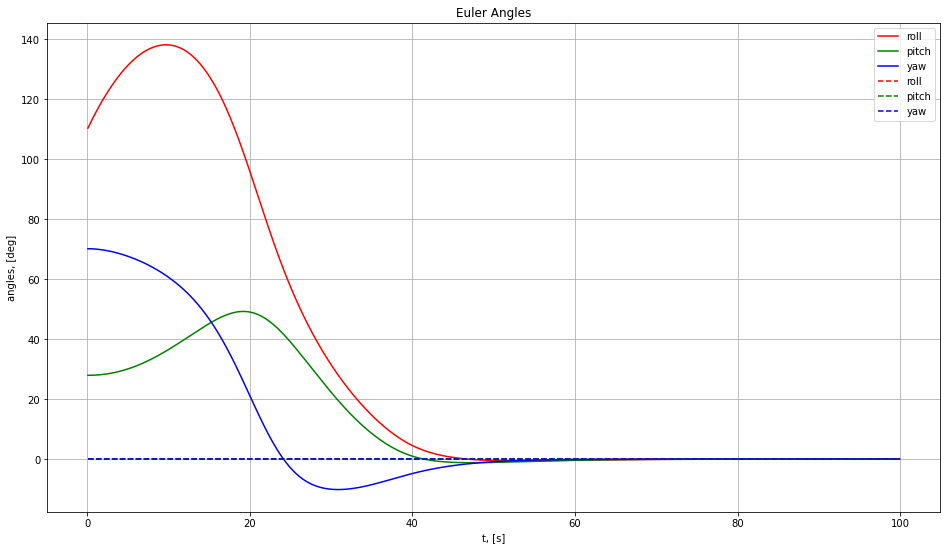

In [56]:
import multiprocessing
import itertools
from joblib import Parallel, delayed
import time


fig1 = plt.figure(figsize=(16,9))
ax1 = fig1.add_subplot(1,1,1)

def funcRandom(bound) :
    l = np.random.randint(low = 0, high = 2, size = 1)
    if l == 0 : 
        return np.random.rand(1, 1) * bound
    else : 
        return np.random.rand(1, 1) * (-1) * bound

def maxabs(x) : 
    return np.amax(np.absolute(x))

def kCalculate(e_array, th, t_eval, n, bound2) :
    k_pos = 0
    k_neg = 0
    
    for i in range(n) : 
        index = int(np.random.rand(1, 1) * (len(t_eval) - 1))
        y_i = funcRandom(bound2)
        
        if (y_i <= e_array[index] and e_array[index] >= th and y_i >= th) : 
            k_pos += 1
            #Раскомментить для того, чтобы убедиться, что точка правильно считается выше или ниже нужного положения
            #ax1.plot(t_eval[index], y_i, marker = 'o', color = 'red', markersize = 3)
        elif (y_i >= e_array[index] and e_array[index] < th and y_i < th) : 
            k_neg+= 1
            #Раскомментить для того, чтобы убедиться, что точка правильно считается выше или ниже нужного положения
            #ax1.plot(t_eval[index], y_i, marker = 'o', color = 'green', markersize = 3)
            
    return k_pos + k_neg


def MonteCarlo(tf, t_eval, roll, pitch, yaw, roll_t, pitch_t, yaw_t) :
    if flag == 0 : 
        print('Integration method: Monte Carlo, selected parameters:\n')
    bound1 = tf
    max_array = np.array([maxabs(roll), maxabs(pitch), maxabs(yaw)])
    bound2 = maxabs(max_array)
    n = 1000
    if flag == 0 : 
        print('n = ' + str(n))
    
    k_roll = kCalculate(roll, roll_t, t_eval, n, bound2)
    k_pitch = kCalculate(pitch, pitch_t, t_eval, n, bound2)
    k_yaw = kCalculate(yaw, yaw_t, t_eval, n, bound2)
    
    #Раскомментить для того, чтобы убедиться, что точка правильно считается выше или ниже нужного положения
    #k_roll = 0
    #k_pitch = 0
    
    mkint_roll = k_roll/n * bound1 * 2 * bound2
    mkint_pitch = k_pitch/n * bound1 * 2 * bound2
    mkint_yaw = k_yaw/n * bound1 * 2 * bound2
    
    return mkint_roll + mkint_pitch + mkint_yaw

def trapezoidal_mk(i, roll, pitch, yaw, t_eval) : 
    return (roll[i] + roll[i-1] + pitch[i] + pitch[i-1] + yaw[i] + yaw[i-1]) * (t_eval[i] - t_eval[i-1]) / 2

def trapezoidal(t_eval, roll, pitch, yaw) : 
    roll = np.absolute(roll)
    pitch = np.absolute(pitch)
    yaw = np.absolute(yaw)
    num_cores = multiprocessing.cpu_count()
    n_jobs = 1
    inputs = range(1, len(t_eval) - 1)
    
    results = Parallel(n_jobs = n_jobs)(delayed(trapezoidal_mk)(i, roll, pitch, yaw, t_eval) for i in inputs)
    mk = np.sum(results)
    
    return mk

def direct_search_kw(j, kq_array, sat, ctrl, x_0, t0, tf, t_eval) : 
    ctrl.kq = kq_array[j]
    sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
    x = sol.y.T
    t = sol.t[1:]
    #Вычисление углов из полученного решения
    roll, pitch, yaw = quat2rpy_deg(x[1:,0], x[1:,1], x[1:,2], x[1:,3])
    roll_t, pitch_t, yaw_t = quat2rpy_deg(ctrl.q_req[0], ctrl.q_req[1], ctrl.q_req[2], ctrl.q_req[3])
            
    #mk = MonteCarlo(tf, t_eval, roll, pitch, yaw, roll_t, pitch_t, yaw_t)
    mk = trapezoidal(t_eval, roll, pitch, yaw)
        
    return mk

def direct_search_kqkw(i, j, kw_array, kq_array, sat, ctrl, x_0, t0, tf, t_eval) : 
    ctrl.kw = kw_array[i]
    ctrl.kq = kq_array[j]
    
    sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
    x = sol.y.T
    t = sol.t[1:]
    #Вычисление углов из полученного решения
    roll, pitch, yaw = quat2rpy_deg(x[1:,0], x[1:,1], x[1:,2], x[1:,3])
    roll_t, pitch_t, yaw_t = quat2rpy_deg(ctrl.q_req[0], ctrl.q_req[1], ctrl.q_req[2], ctrl.q_req[3])
            
    #mk = MonteCarlo(tf, t_eval, roll, pitch, yaw, roll_t, pitch_t, yaw_t)
    mk = trapezoidal(t_eval, roll, pitch, yaw)
        
    return mk

def direct_search(sat, ctrl, x_0, t0, tf, t_eval) : 
    print('Search method: direct search, selected parameters:\n')
    num = 300
    minmk = -1
    finish = 1
    kw_array = np.linspace(0.001, finish, num)
    kq_array = np.linspace(0.001, finish, num)
    kw_opt = -1
    kq_opt = -1
    mk_array = np.zeros(len(kw_array))
    print('num = ' + str(num))
    print('finish = ' + str(finish))
    print('tf = ' + str(tf))
    print('trq_max = ' + str(ctrl.trq_max))
    print('omega_req = ' + str(ctrl.omega_req))
    print('q_req = [' + str(ctrl.q_req[0]) + ', ' + str(ctrl.q_req[1]) + ', ' + str(ctrl.q_req[2]) + ', ' + str(ctrl.q_req[3]) + ']')
    print('x0 = [' + str(x_0[0]) + ', ' + str(x_0[1]) + ', ' + str(x_0[2]) + ', ' + str(x_0[3]) + ', ' + str(x_0[4]) + ', ' + str(x_0[5]) + ', ' + str(x_0[6]) + ']')
    print('\n')
    
    num_cores = multiprocessing.cpu_count()
    n_jobs = num_cores
    inputs = itertools.product(range(len(kw_array)), range(len(kq_array)))
    mk = Parallel(n_jobs = n_jobs)(delayed(direct_search_kqkw)(i, j, kw_array, kq_array, sat, ctrl, x_0, t0, tf, t_eval) for i, j in inputs)
    minmk = np.amin(mk)
    i_min = np.argmin(mk)
    
    kw_opt = kw_array[i_min // len(kw_array)]
    kq_opt = kq_array[i_min % len(kw_array)]
    
    return kw_opt, kq_opt, minmk

class Parameters(object):
    pass
#Задание параметров системы
sat = Parameters()
sat.J = np.diag(np.array([1200, 2200, 3100]))
#sat.J = np.array([[1200, 100, -200], [100, 2200, 300], [-200, 300, 3100]])
sat.J_inv = np.linalg.inv(sat.J)

#Задание параметров управления(коэффициенты kw,kq, максимальный момент,требуемая угловая скорость, квартенион)
ctrl = Parameters()
ctrl.trq_max = 10
#Считаем требуемую угловую скорость нулевой
ctrl.omega_req = np.zeros(3)
ctrl.q_req = np.array([1., 0., 0., 0.])

#Начальные условия
#Первые четыре элемента x_0 соответсвуют квартениону, остальные w
x_0 = np.array([0.57, 0.57, 0.57, 0.159, 0.1, 0, 0])
t0 = 0.
tf = 100.
t_eval = np.arange(t0, tf, 0.1)

start_time = time.time()
kw_opt, kq_opt, minmk = direct_search(sat, ctrl, x_0, t0, tf, t_eval)
print('Search time: ' + str(time.time() - start_time) + ' seconds')
ctrl.kw = kw_opt
ctrl.kq = kq_opt
print('Optimal kw = ' + str(kw_opt) + ', optimal kq = ' + str(kq_opt) + ', integral = ' + str(minmk))
print('Solution based on such kw and kq:')


#Решение системы
sol = solve_ivp(lambda t, x: rhs(t, x, sat, ctrl), (t0,tf), x_0, t_eval = t_eval)
x = sol.y.T
t = sol.t[1:]
#Вычисление углов из полученного решения
roll, pitch, yaw = quat2rpy_deg(x[1:,0], x[1:,1], x[1:,2], x[1:,3])
roll_t, pitch_t, yaw_t = quat2rpy_deg(ctrl.q_req[0], ctrl.q_req[1], ctrl.q_req[2], ctrl.q_req[3])

roll_t_array = np.zeros(len(t)) + roll_t
pitch_t_array = np.zeros(len(t)) + pitch_t
yaw_t_array = np.zeros(len(t)) + yaw_t

ax1.set_title("Euler Angles")

ax1.plot(t, roll, label = 'roll', color = 'red')
ax1.plot(t, pitch, label = 'pitch', color = 'green')
ax1.plot(t, yaw, label = 'yaw', color = 'blue')

ax1.plot(t, roll_t_array, linestyle = '--', color = 'red', label = 'roll')
ax1.plot(t, pitch_t_array, linestyle = '--', color = 'green', label = 'pitch')
ax1.plot(t, yaw_t_array, linestyle = '--', color = 'blue', label = 'yaw')

ax1.set_ylabel(r'angles, [deg]')
ax1.set_xlabel(r't, [s]')
ax1.grid(True)
ax1.legend()
plt.show()

